# Working with non-8-bit images

This example shows how you can augment 16-bit TIFF images. 16-bit images are used in satellite imagery. The following technique could also be applied to all non-8-bit images (i.e., 24-bit images, 32-bit images. etc.).

### Import the required libraries

In [1]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

### Define the visualization function

In [2]:
def visualize(image):
    # Divide all values by 65535 so we can display the image using matplotlib
    image = image / 65535
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

### Read the 16-bit TIFF image from the disk

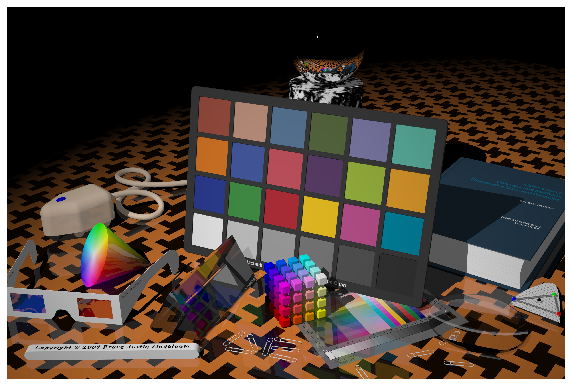

In [3]:
# The image is taken from http://www.brucelindbloom.com/index.html?ReferenceImages.html
# © Bruce Justin Lindbloom
image = cv2.imread('images/DeltaE_16bit_gamma2.2.tif', cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

Note: OpenCV may read incorrectly some TIFF files. Consider using `tifffile` - https://github.com/blink1073/tifffile

### Define an augmentation pipeline that works with 16-bit TIFF images

Under the hood, Albumentations supports two data types that describe the intensity of pixels: 
- `np.uint8`, an unsigned 8-bit integer that can define values between 0 and 255.
- `np.float32`, a floating-point number with single precision. For `np.float32` input, Albumentations expects that value will lie in the range between 0.0 and 1.0.

Albumentations has a dedicated transformation called `ToFloat` that takes a NumPy array with data types such as `np.uint16`, `np.uint32`, etc. (so any datatype that used values higher than 255 to represent pixel intensity) and converts it to a NumPy array with the `np.float32` datatype. Additionally, this transformation divides all input values to lie in the range `[0.0, 1.0]`. By default, if the input data type is `np.uint16`, all values are divided by 65536, and if the input data type is `np.uint32`, all values are divided by 4294967295. You can specify your divider in the `max_value` parameter.

The augmentation pipeline for non-8-bit images consists of the following stages:

- First, you use the `ToFloat` transform to convert an input image to float32. All values in the converted image will lie in the range `[0.0, 1.0]`.
- Then you use all the necessary image transforms.
- Optionally you could use the `FromFloat` transform at the end of the augmentation pipeline to convert the image back to its original data type.

In [4]:
transform = A.Compose([
    A.ToFloat(max_value=65535.0),

    A.RandomRotate90(),
    A.Flip(),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
    ], p=0.2),        
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.3),

    A.FromFloat(max_value=65535.0),
])

We fix the random seed for visualization purposes, so the augmentation will always produce the same result. In a real computer vision pipeline, you shouldn't fix the random seed before applying a transform to the image because, in that case, the pipeline will always output the same image. The purpose of image augmentation is to use different transformations each time.

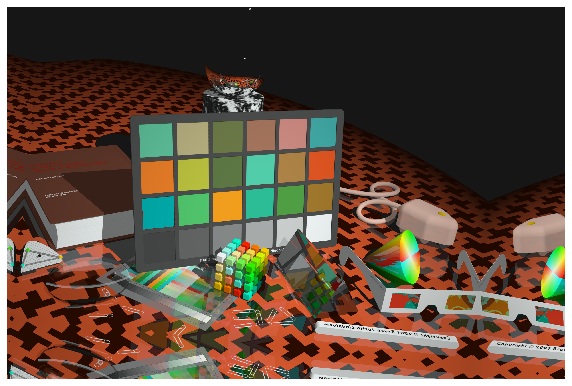

In [5]:
random.seed(7)
augmented = transform(image=image)
visualize(augmented['image'])